<a href="https://colab.research.google.com/github/QiSiyu/Delta-Modelling-ANN/blob/main/Test_DSM2_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## Mount Google Drive

In [1]:
from google.colab import drive
import pandas as pd
import os
import glob
import numpy as np
import tensorflow as tf
import time
import sys
import functools

google_drive_dir = 'DeltaModelling'

drive.mount('/content/drive',force_remount=True)
sys.path.append(os.path.join('/content/drive','My Drive',google_drive_dir))

data_resolution = '1D' # '1D' : daily; '15min' : 15-minute
key_stations = ['RSAN018', 'RSAC092', 'CHSWP003', 'CHDMC006', 'SLMZU025', 'ROLD059', 'CHVT000']


# daily data: <= 7306 samples, with 1282 input variables & 25 stations
# 15-min data: TODO

Mounted at /content/drive


## Define hyper-parameters

In [2]:
batch_size = 100
num_daily_values = 8
avg_window_size = 11
num_windows = 10
training_set_ratio=0.8

window_size = num_windows * avg_window_size + num_daily_values

# True: convolutional layer is trainable; False: conv layer is fixed
train_conv = True

model_folder = 'saved_models'


# Define evaluation functions

In [3]:
def gradient_importance(dataset, model, steps):
    '''Evaluates each input feature's contribution to the model outputs
    Returns: an 1D numpy array'''
    importance_vector = np.zeros((model.input_shape[-1],))
    step = 0
    for features, ec in dataset:
        if step > steps:
            break
        features = tf.Variable(features, dtype=tf.float32)
        with tf.GradientTape() as tape:
            predictions = model(features)
        grads = tape.gradient(predictions, features)
        importance_vector += tf.reduce_mean(grads, axis=1).numpy()[0]
        step+=1
        
    return importance_vector

def generate_output_sequence(dataset, model, steps):
    '''Get observations and computes corresponding ANN predictions.
    Returns: two 1D numpy arrays, one as true observations, another as ANN predictions'''
    target_output_sequence = []
    predicted_output_sequence = []
    step = 0
    for features, ec in dataset:
        if step > steps:
            break
        predictions = model(features)
        target_output_sequence.append(ec)
        predicted_output_sequence.append(predictions)
        step+=1
        
    return target_output_sequence,predicted_output_sequence

# Load Data

In [4]:
data_files=sorted(tf.io.gfile.glob(os.path.join('/content/drive','My Drive',google_drive_dir,'data_%s_*.csv')%data_resolution))

fline=open(data_files[0]).readline().rstrip() # Reading column names 
variables=fline.split(',')

input_variables = [var for var in variables if 'input' in var]
output_variables = [var for var in variables if 'target' in var]
selected_input_variables = input_variables[0:]


DATASET_SIZE = -len(data_files) # number reserved for headers

for data_file in data_files:
    for row in open(data_file):
        DATASET_SIZE += 1
train_size = int(0.8 * DATASET_SIZE)
print('%d samples, each has %d input variable(s) & %d output station(s)' % (DATASET_SIZE, len(input_variables),len(output_variables)))


7306 samples, each has 1282 input variable(s) & 25 output station(s)


## Data preprocessing functions

In [5]:
def pack_features_vector(features,ec):
    """Pack the features into a single array."""
    features = tf.stack([tf.cast(x,tf.float32) for x in list(features.values())], axis=1)
    if ec.dtype==tf.float32:
        return features, ec
    else:
        return features, tf.strings.to_number(ec) if not tf.reduce_any(ec== b'') else tf.convert_to_tensor([float('NaN')],dtype=tf.float32)

def apply_window(dataset, window_size, batch_size,training_set_ratio=0.8):
    windowed_dataset = dataset.map(pack_features_vector)
    windowed_dataset = windowed_dataset.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y)))
    filter_nan_in_ec = lambda x, y: not tf.reduce_any(tf.math.logical_or(tf.math.is_nan(y),tf.math.less_equal(y,tf.constant([0],dtype=tf.float32))))
    windowed_dataset = windowed_dataset.filter(filter_nan_in_ec)

    num_samples = 0
    for _ in windowed_dataset:
        num_samples += 1
    train_size = int(training_set_ratio*num_samples)
    if num_samples - train_size < window_size:
        print('Available dataset size (%d training, %d test) smaller than window size (%d), will skip' % (train_size, num_samples - train_size,window_size))
        return None, None, 0, 0

    windowed_dataset = windowed_dataset.window(window_size, shift=1, drop_remainder=True)
    windowed_dataset = windowed_dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(window_size), y)))
 
    windowed_trainset = windowed_dataset.take(train_size)
    windowed_testset = windowed_dataset.skip(train_size)

    return windowed_trainset.batch(batch_size).repeat(),\
        windowed_testset.batch(batch_size).repeat(),\
        train_size,\
        num_samples-train_size

In [6]:
def load_and_window_dataset(data_files, input_variables, output_variable, window_size,batch_size,training_set_ratio=0.8):
    assert len(output_variable)==1, 'This script is for single-station estimation!'

    # 1282 input variables, 25 salinity (output) stations
    ec_csv_ds = tf.data.experimental.make_csv_dataset(
        data_files,
        batch_size=1,
        na_value='-2.000', # missing entries in output
        select_columns=input_variables+output_variable,
        label_name=output_variable[0],# work on first output station
        num_epochs=1,
        ignore_errors=False,
        shuffle=False)

    windowed_trainset,windowed_testset,train_size,test_size = apply_window(ec_csv_ds, window_size, batch_size,training_set_ratio)

    #     for feature, label in windowed_testset.take(1):
    #         print('%s windowed feature shape: ' % (output_variable[0]), feature.shape, 'Label shape: ', label.shape)

    return windowed_trainset, windowed_testset, train_size,test_size


# Build model

In [7]:
def build_ann(input_shape,num_daily_values, num_windows, conv_filter_init=None,train_conv=True,print_details=True):
    conv_layer = tf.keras.layers.Conv1D(num_daily_values+num_windows, 1, activation=None,
                              kernel_initializer=conv_filter_init,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0),)
    conv_layer.trainable=train_conv
    
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Permute((2,1))(inputs)
    x = tf.keras.layers.Masking(mask_value=-1)(x)
    x = conv_layer(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(10, activation="elu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(10, activation="elu")(x)
    # x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1)(x)
    outputs = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="ann_model")
    if print_details:
        model.summary()
    return model

# Begin evaluation

In [9]:
import time

importance_dict = {} # a dictionary that stores { station_name : feature_importance_vector}
target_sequences = {} # a dictionary that stores { station_name : observed_salinity}
pred_sequences = {} # a dictionary that stores { station_name : ANN_predicted_salinity}
ann_number = 0

for ii, station in enumerate(output_variables): # loop over all stations
    path_checkpoint = "%s_%s_conv_checkpoint.h5" % (station.replace('target',''),('train' if train_conv else 'freeze'))
    try:
        start = time.time()
        # build model backbone and load checkpoints
        model = build_ann(input_shape=(window_size, len(selected_input_variables)),
                          num_daily_values=num_daily_values,
                          num_windows=num_windows,
                          print_details=False)

        model.load_weights(os.path.join('/content/drive','My Drive',google_drive_dir,model_folder,path_checkpoint))
        ann_number += 1
        print('Loaded model #%d for Station %s' % (ann_number, station.replace('target','')))
        # prepare dataset
        windowed_trainset, windowed_testset, train_size, test_size = load_and_window_dataset(data_files, 
                                                                                            selected_input_variables,
                                                                                            [station],
                                                                                            window_size,
                                                                                            batch_size,
                                                                                            training_set_ratio)
    
        importance_dict[station] = gradient_importance(windowed_trainset,model,steps=train_size//batch_size)
          
        if station.replace('target','') in key_stations: 
            # collect observation and prediction sequences for key stations
            targets, preds = generate_output_sequence(windowed_testset,model,steps=test_size//batch_size)
            target_sequences[station] = np.concatenate(targets)
            pred_sequences[station] = np.concatenate(preds)
        print('Finished evaluation in %.2f seconds' % (time.time() - start))
    except Exception as e: 
        # if encounters an error, print the message below and skip this station
        print('Cannot load model, skipping station %s' % station.replace('target',''))
        pass

Loaded model #1 for Station CHDMC006
Finished evaluation in 88.00 seconds
Loaded model #2 for Station CHSWP003
Finished evaluation in 77.65 seconds
Loaded model #3 for Station CHVCT000
Finished evaluation in 67.79 seconds
Loaded model #4 for Station OLD_MID
Finished evaluation in 48.75 seconds
Loaded model #5 for Station ROLD024
Finished evaluation in 45.55 seconds
Loaded model #6 for Station ROLD059
Finished evaluation in 82.21 seconds
Loaded model #7 for Station RSAC064
Finished evaluation in 45.12 seconds
Loaded model #8 for Station RSAC075
Finished evaluation in 45.51 seconds
Loaded model #9 for Station RSAC081
Finished evaluation in 48.52 seconds
Loaded model #10 for Station RSAC092
Finished evaluation in 78.70 seconds
Loaded model #11 for Station RSAC101
Finished evaluation in 47.35 seconds
Loaded model #12 for Station RSAN007
Finished evaluation in 44.02 seconds
Loaded model #13 for Station RSAN018
Finished evaluation in 79.74 seconds
Loaded model #14 for Station RSAN032
Finishe

## Plot input feature importance map for each station

Input feature importance plot saved to /content/drive/My Drive/DeltaModelling/importance_trainable_conv.jpg


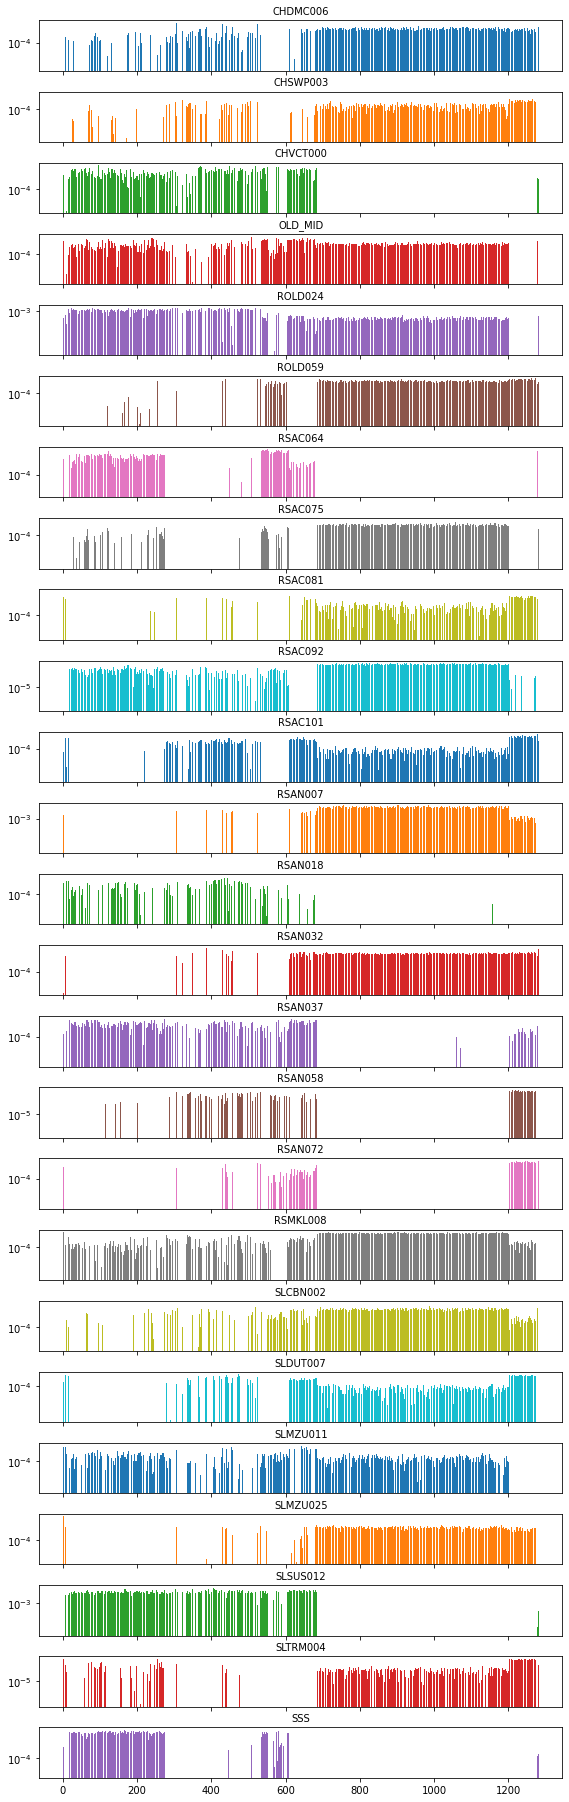

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(importance_dict), sharex=True, figsize=(8,len(importance_dict)))
fig.tight_layout()

for ii, (station, importance)  in enumerate(list(importance_dict.items())):
    axes[ii].bar(range(len(importance)),importance,color='C%d' % ii)
    axes[ii].set_title(station.replace('target',''),fontsize=10)
    axes[ii].set_yscale('log')
plt.savefig(os.path.join('/content/drive','My Drive',google_drive_dir,'importance_%s_conv.jpg' % ('trainable' if train_conv else 'fixed')),bbox_inches='tight',dpi=300)
print('Input feature importance plot saved to %s' % os.path.join('/content/drive','My Drive',google_drive_dir,'importance_%s_conv.jpg' % ('trainable' if train_conv else 'fixed')))

## Plot observations vs. ANN predictions for key stations

Observation vs ANN prediction figure saved to /content/drive/My Drive/DeltaModelling/output_sequence_trainable_conv.jpg


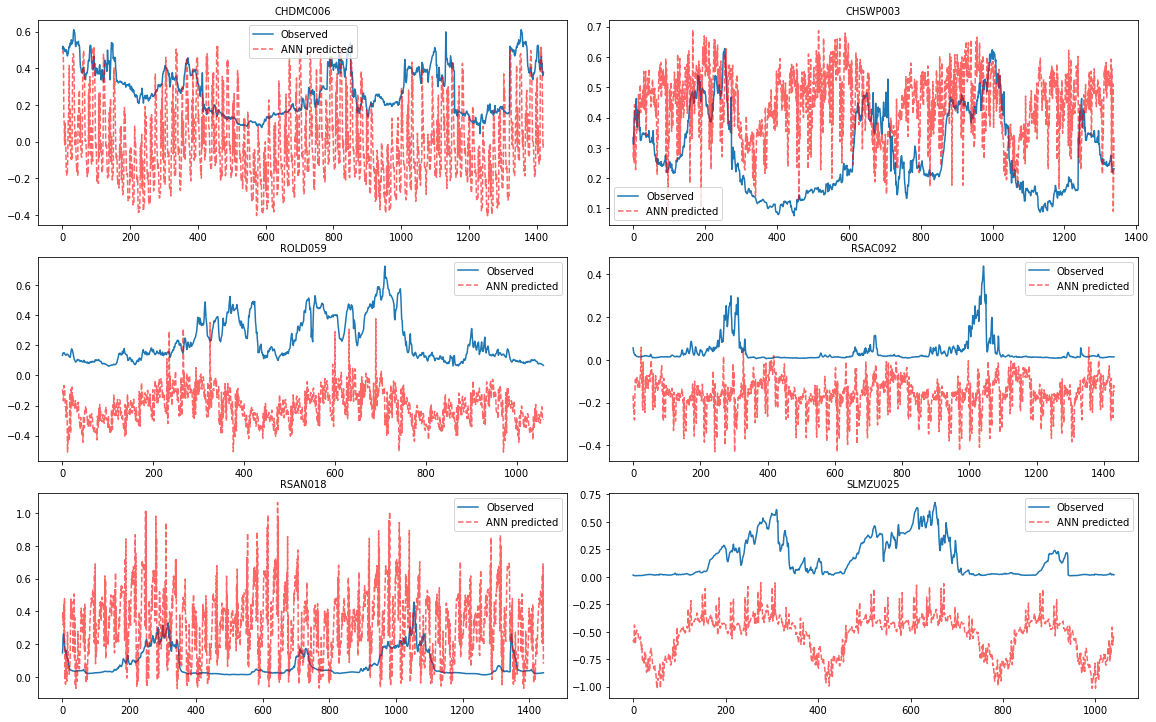

In [12]:
fig, axes = plt.subplots(3,2,figsize=(16,10))
fig.tight_layout()

for ii, (station, targets) in enumerate(list(target_sequences.items())):
    axes[ii//2,ii%2].plot(targets,'-',color='C0')
    axes[ii//2,ii%2].plot(pred_sequences[station],'--',color='r',alpha=0.6)
    axes[ii//2,ii%2].set_title(station.replace('target',''),fontsize=10)
    axes[ii//2,ii%2].legend(['Observed', 'ANN predicted'])

plt.savefig(os.path.join('/content/drive','My Drive',google_drive_dir,'output_sequence_%s_conv.jpg' % ('trainable' if train_conv else 'fixed')),bbox_inches='tight',dpi=300)
print('Observation vs ANN prediction figure saved to %s' % (os.path.join('/content/drive', 'My Drive', google_drive_dir, 'output_sequence_%s_conv.jpg' % ('trainable' if train_conv else 'fixed'))) )